In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("../data/Google.csv")
df = pd.DataFrame(data=data)

In [3]:
df.head()

,Unnamed: 0,open,high,low,close,adjclose,volume,ticker
0,2016-01-04,37.150002,37.202999,36.562901,37.091999,37.091999,65456000,GOOG
1,2016-01-05,37.322498,37.599998,36.931999,37.129002,37.129002,39014000,GOOG
2,2016-01-06,36.500000,37.359001,36.445999,37.181000,37.181000,38940000,GOOG
3,2016-01-07,36.515499,36.924999,35.952999,36.319500,36.319500,59274000,GOOG
4,2016-01-08,36.572498,36.661499,35.650002,35.723499,35.723499,49018000,GOOG


In [4]:
df.rename(columns={'Unnamed: 0': 'timestamp'},inplace=True)

In [5]:
df.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
adjclose     0
volume       0
ticker       0
dtype: int64

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2113 non-null   datetime64[ns]
 1   open       2113 non-null   float64       
 2   high       2113 non-null   float64       
 3   low        2113 non-null   float64       
 4   close      2113 non-null   float64       
 5   adjclose   2113 non-null   float64       
 6   volume     2113 non-null   int64         
 7   ticker     2113 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [7]:
df.set_index('timestamp', inplace=True)

In [8]:
if df.index.duplicated().any():
    print(f"\nFound {df.index.duplicated().sum()} duplicate timestamps. Removing duplicates...")
    df = df[~df.index.duplicated(keep='first')]
    print("Duplicates removed. DataFrame head:")
    print(df.head())
else:
    print("\nNo duplicate timestamps found.")


No duplicate timestamps found.


In [9]:
df.head()

,open,high,low,close,adjclose,volume,ticker
timestamp,,,,,,,
2016-01-04,37.150002,37.202999,36.562901,37.091999,37.091999,65456000,GOOG
2016-01-05,37.322498,37.599998,36.931999,37.129002,37.129002,39014000,GOOG
2016-01-06,36.500000,37.359001,36.445999,37.181000,37.181000,38940000,GOOG
2016-01-07,36.515499,36.924999,35.952999,36.319500,36.319500,59274000,GOOG
2016-01-08,36.572498,36.661499,35.650002,35.723499,35.723499,49018000,GOOG


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
date_range = pd.date_range(start='2016-01-01', periods=200, freq='B') # 200 business days
np.random.seed(42)
dummy_data = {
    'open': np.random.uniform(30, 50, 200).cumsum() + 100,
    'high': np.random.uniform(30, 50, 200).cumsum() + 101,
    'low': np.random.uniform(30, 50, 200).cumsum() + 99,
    'close': np.random.uniform(30, 50, 200).cumsum() + 100,
    'adjclose': np.random.uniform(30, 50, 200).cumsum() + 100,
    'volume': np.random.randint(10_000_000, 100_000_000, 200),
    'ticker': ['GOOG'] * 200
}
# Adjust high, low relative to open/close for realism
dummy_data['high'] = np.maximum(dummy_data['open'], dummy_data['close']) + np.random.uniform(0.5, 2, 200)
dummy_data['low'] = np.minimum(dummy_data['open'], dummy_data['close']) - np.random.uniform(0.5, 2, 200)

df = pd.DataFrame(dummy_data, index=date_range)
df.index.name = 'timestamp'

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2016-01-01 to 2016-10-06
Freq: B
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      200 non-null    float64
 1   high      200 non-null    float64
 2   low       200 non-null    float64
 3   close     200 non-null    float64
 4   adjclose  200 non-null    float64
 5   volume    200 non-null    int64  
 6   ticker    200 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 12.5+ KB


In [14]:
target_column = 'close'

# 1. Daily Returns
df['daily_return'] = df[target_column].pct_change()

# 2. Simple Moving Averages (SMA) - common lags 20, 50
df['SMA_20'] = df[target_column].rolling(window=20).mean()
df['SMA_50'] = df[target_column].rolling(window=50).mean()

# 3. Exponential Moving Averages (EMA) - often more responsive
df['EMA_20'] = df[target_column].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df[target_column].ewm(span=50, adjust=False).mean()

# 4. Volatility (Standard Deviation of returns over a period)
df['volatility_20'] = df['daily_return'].rolling(window=20).std()

# 5. Price-Volume Trend (PVT) - A momentum indicator
# This requires previous PVT, so it's a bit more complex.
# For simplicity, let's skip complex indicators for now to focus on core steps.
# we can add, e.g., RSI, MACD, etc., you can use libraries like 'ta' or 'stockstats'.

# Remove rows with NaN values created by rolling windows (e.g., first 49 rows for SMA_50)
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151 entries, 2016-03-10 to 2016-10-06
Freq: B
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           151 non-null    float64
 1   high           151 non-null    float64
 2   low            151 non-null    float64
 3   close          151 non-null    float64
 4   adjclose       151 non-null    float64
 5   volume         151 non-null    int64  
 6   ticker         151 non-null    object 
 7   daily_return   151 non-null    float64
 8   SMA_20         151 non-null    float64
 9   SMA_50         151 non-null    float64
 10  EMA_20         151 non-null    float64
 11  EMA_50         151 non-null    float64
 12  volatility_20  151 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 16.5+ KB


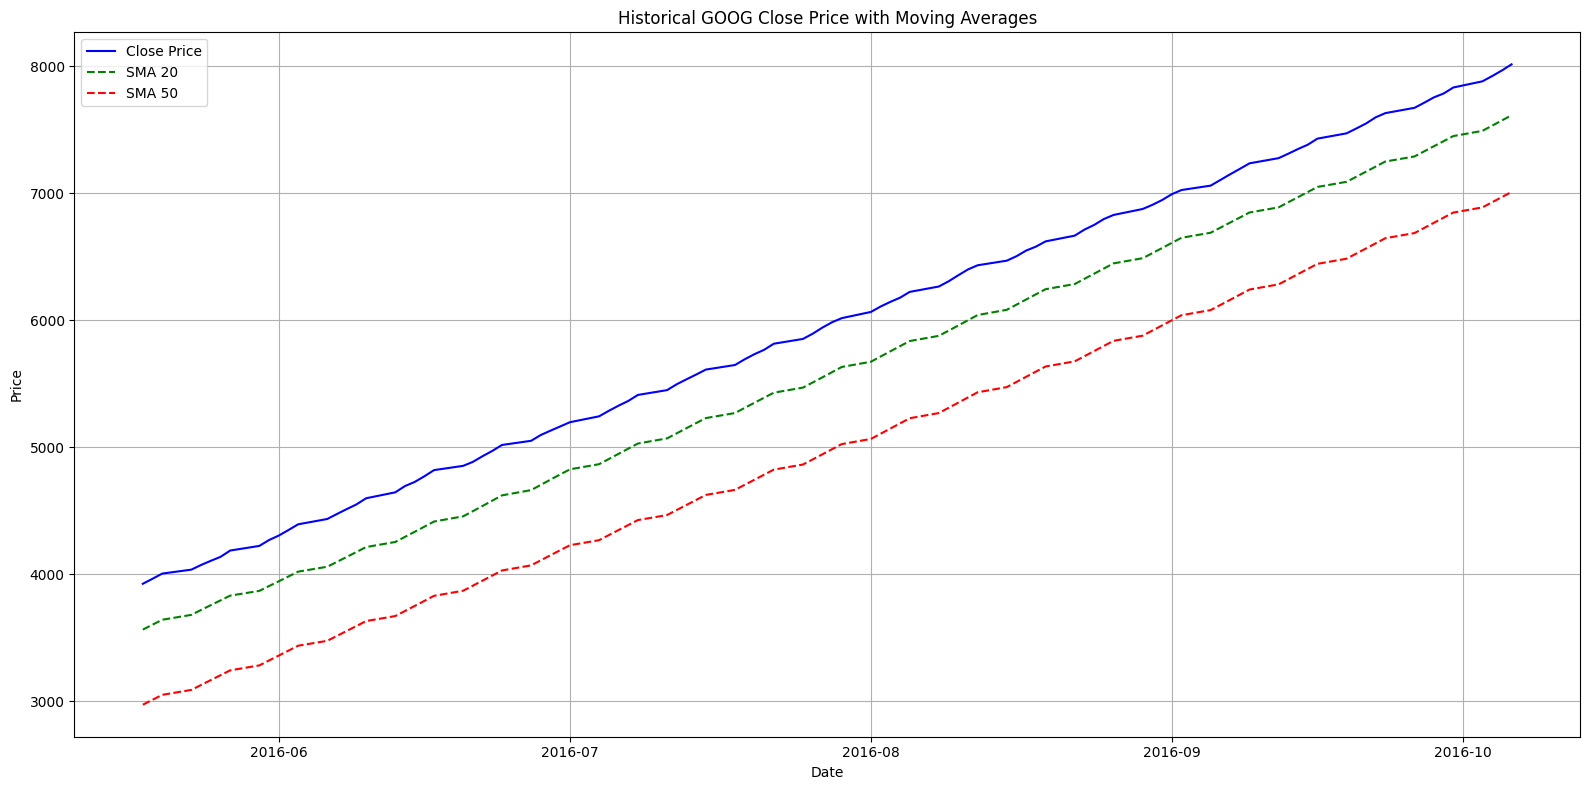

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['SMA_20'], label='SMA 20', color='green', linestyle='--')
plt.plot(df.index, df['SMA_50'], label='SMA 50', color='red', linestyle='--')
plt.title(f'Historical {df["ticker"].iloc[0]} Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

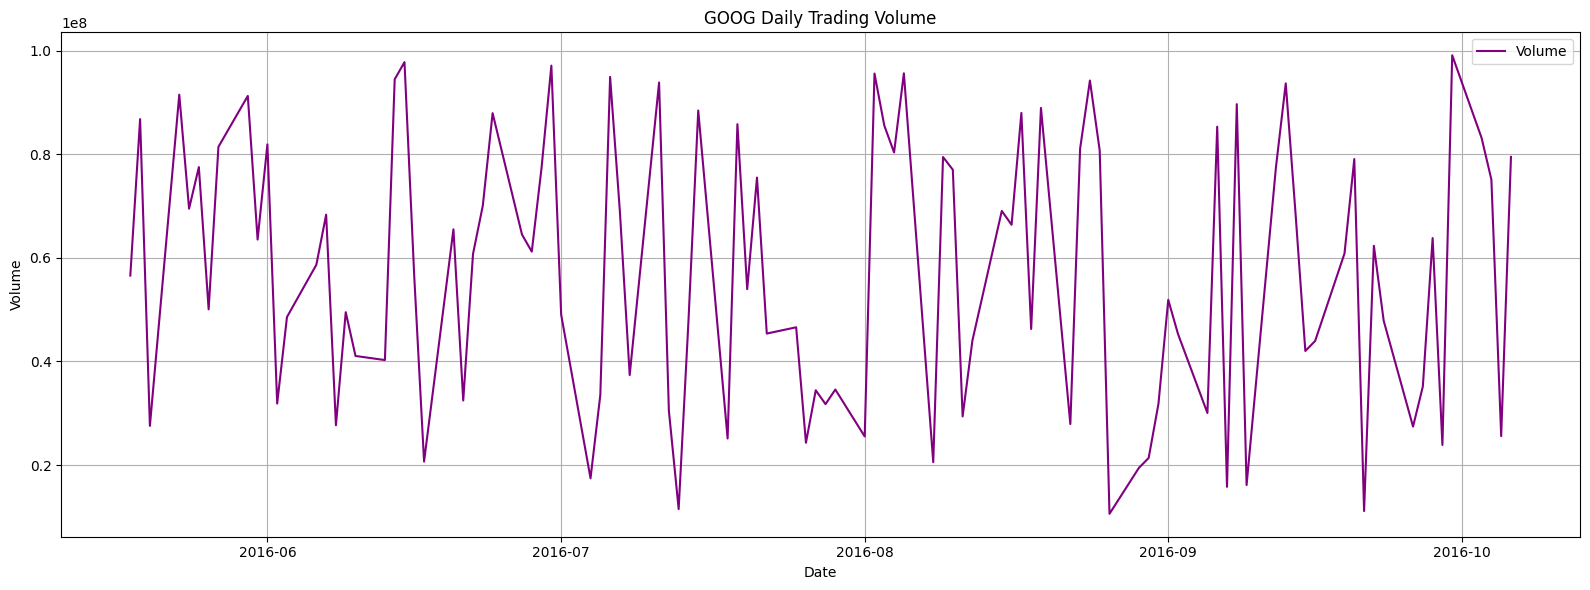

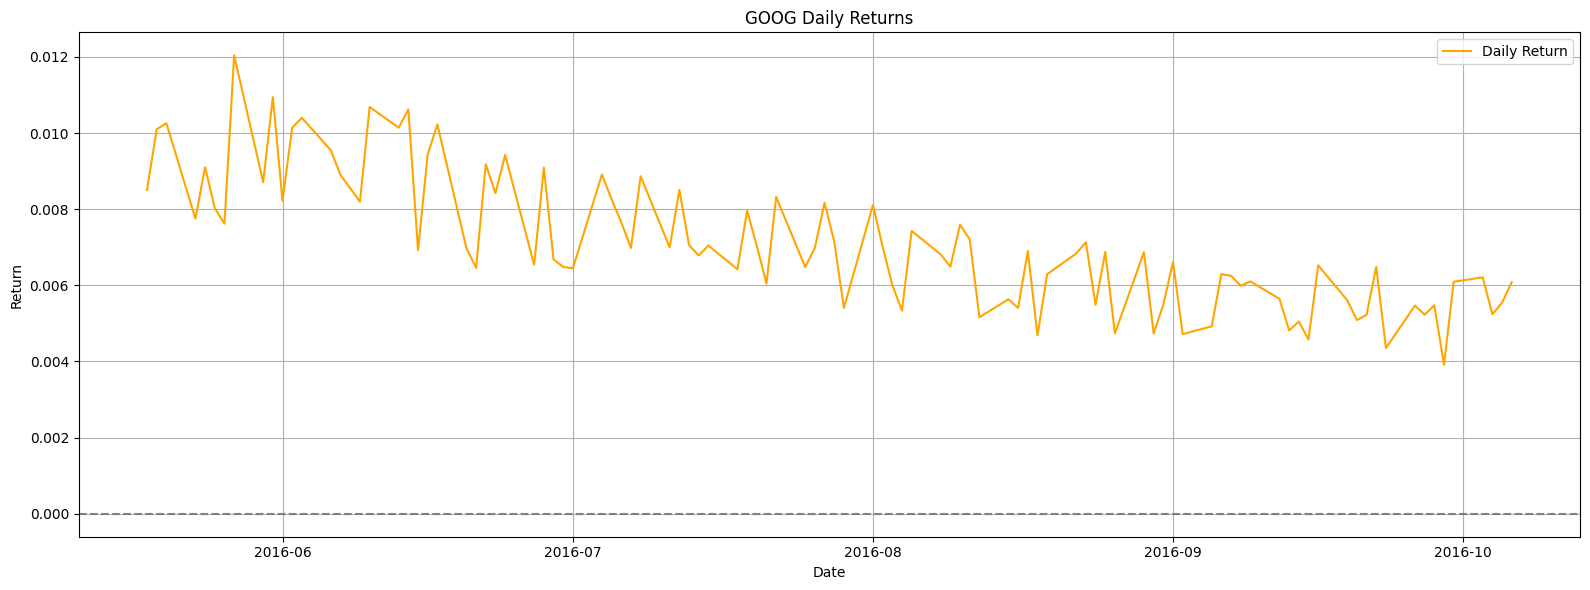

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['volume'], label='Volume', color='purple')
plt.title(f'{df["ticker"].iloc[0]} Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(df.index, df['daily_return'], label='Daily Return', color='orange')
plt.title(f'{df["ticker"].iloc[0]} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axhline(0, color='gray', linestyle='--') # Add a line at zero for reference
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Select features for scaling. It's common to scale all numerical features, including the target.
# 'ticker' is categorical and 'timestamp' is index, so exclude them.
features_to_scale = [col for col in df.columns if col not in ['ticker']] # Exclude ticker

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the selected features and transform the data
# We will use the scaled data to create sequences.
# Important: Fit only on training data (which we will define shortly)
# For now, let's scale the whole dataset for simplicity in demonstrating sequence creation.
# In a real scenario, you'd fit on training features and then transform both train/test features.
scaled_data = scaler.fit_transform(df[features_to_scale])

# Convert scaled data back to a DataFrame for easier handling
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale, index=df.index)

print("\nScaled DataFrame head (only showing first 5 rows and selected columns for brevity):")
print(scaled_df.head())
print("\nDescriptive statistics of scaled data:")
scaled_df.describe()


Scaled DataFrame head (only showing first 5 rows and selected columns for brevity):
                open      high       low     close  adjclose    volume  \
timestamp                                                                
2016-05-18  0.000000  0.000000  0.000000  0.000000  0.000000  0.519477   
2016-05-19  0.007984  0.008272  0.009940  0.009684  0.007979  0.860743   
2016-05-20  0.015588  0.015688  0.019724  0.019620  0.016574  0.191639   
2016-05-23  0.026196  0.026523  0.027191  0.027205  0.024257  0.914062   
2016-05-24  0.035206  0.035551  0.036387  0.036183  0.032719  0.665458   

            daily_return    SMA_20    SMA_50    EMA_20    EMA_50  \
timestamp                                                          
2016-05-18      0.564756  0.000000  0.000000  0.000000  0.000000   
2016-05-19      0.760903  0.009610  0.009611  0.009422  0.008594   
2016-05-20      0.780429  0.019151  0.019266  0.018902  0.017259   
2016-05-23      0.472096  0.028640  0.028873  0.028209  

,open,high,low,close,adjclose,volume,daily_return,SMA_20,SMA_50,EMA_20,EMA_50,volatility_20
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,0.495841,0.495933,0.496849,0.496876,0.498418,0.528637,0.393487,0.496694,0.496060,0.496649,0.487424,0.328618
std,0.291134,0.291085,0.292745,0.292849,0.293255,0.294550,0.213202,0.294633,0.293791,0.294403,0.295837,0.231015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250292,0.250482,0.248406,0.248184,0.252914,0.250140,0.223623,0.242984,0.244488,0.244601,0.231190,0.140315
50%,0.494727,0.494768,0.498347,0.498302,0.500567,0.554998,0.364201,0.495413,0.493293,0.495669,0.481838,0.239689
75%,0.740887,0.740948,0.747218,0.747194,0.749158,0.791200,0.533494,0.749334,0.747178,0.748774,0.740374,0.508912
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# --- 4. Sequence Creation ---

# Define the number of timesteps (look-back period)
# This is a hyperparameter you'll tune. Common values are 30, 60, 90, 120 days.
timesteps = 60 # e.g., use past 60 days to predict the next day

X = [] # List to hold input sequences
y = [] # List to hold target values (the price to predict)

# Determine the index of the target column in the scaled_df (e.g., 'close')
# This is crucial for correctly picking the 'y' value from the scaled data.
target_feature_index = scaled_df.columns.get_loc(target_column)

for i in range(timesteps, len(scaled_df)):
    X.append(scaled_df.iloc[i-timesteps:i].values) # Features for the past 'timesteps' days
    y.append(scaled_df.iloc[i, target_feature_index]) # The 'close' price of the current day (i)

X = np.array(X)
y = np.array(y)

print(f"\nShape of X (sequences): {X.shape}") # Should be (num_samples, timesteps, num_features)
print(f"Shape of y (target values): {y.shape}") # Should be (num_samples,)


Shape of X (sequences): (42, 60, 12)
Shape of y (target values): (42,)


In [22]:
# --- 5. Train-Test Split (Chronological) ---

# Define the split ratio (e.g., 80% for training, 20% for testing)
train_split_ratio = 0.8
train_size = int(len(X) * train_split_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\n--- Preprocessing and Data Preparation Complete ---")
print("You now have X_train, y_train, X_test, y_test ready for LSTM model training.")
print("The 'scaler' object is also preserved for inverse transforming predictions later.")



Shape of X_train: (33, 60, 12)
Shape of y_train: (33,)
Shape of X_test: (9, 60, 12)
Shape of y_test: (9,)

--- Preprocessing and Data Preparation Complete ---
You now have X_train, y_train, X_test, y_test ready for LSTM model training.
The 'scaler' object is also preserved for inverse transforming predictions later.


X_train_np shape: (312, 60, 12)
y_train_np shape: (312,)
X_test_np shape: (79, 60, 12)
y_test_np shape: (79,)
Using device: cuda

Model Architecture:
LSTMModel(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Number of parameters: 204929

--- Starting Model Training ---
Epoch [10/100], Loss: 0.005513
Epoch [20/100], Loss: 0.003430
Epoch [30/100], Loss: 0.002559
Epoch [40/100], Loss: 0.002397
Epoch [50/100], Loss: 0.002704
Epoch [60/100], Loss: 0.006707
Epoch [70/100], Loss: 0.001991
Epoch [80/100], Loss: 0.001789
Epoch [90/100], Loss: 0.007395
Epoch [100/100], Loss: 0.001837
--- Training Complete ---


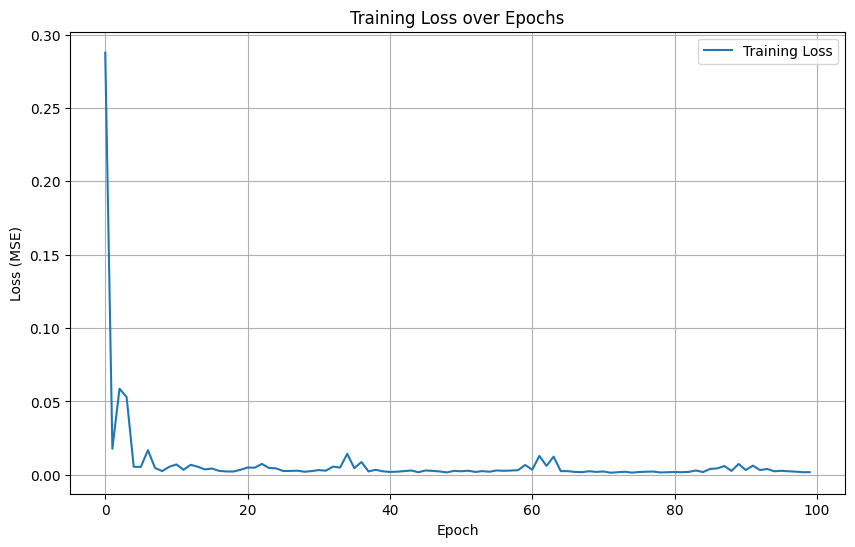


--- Evaluating Model on Test Set ---
Test Loss (MSE): 0.000972


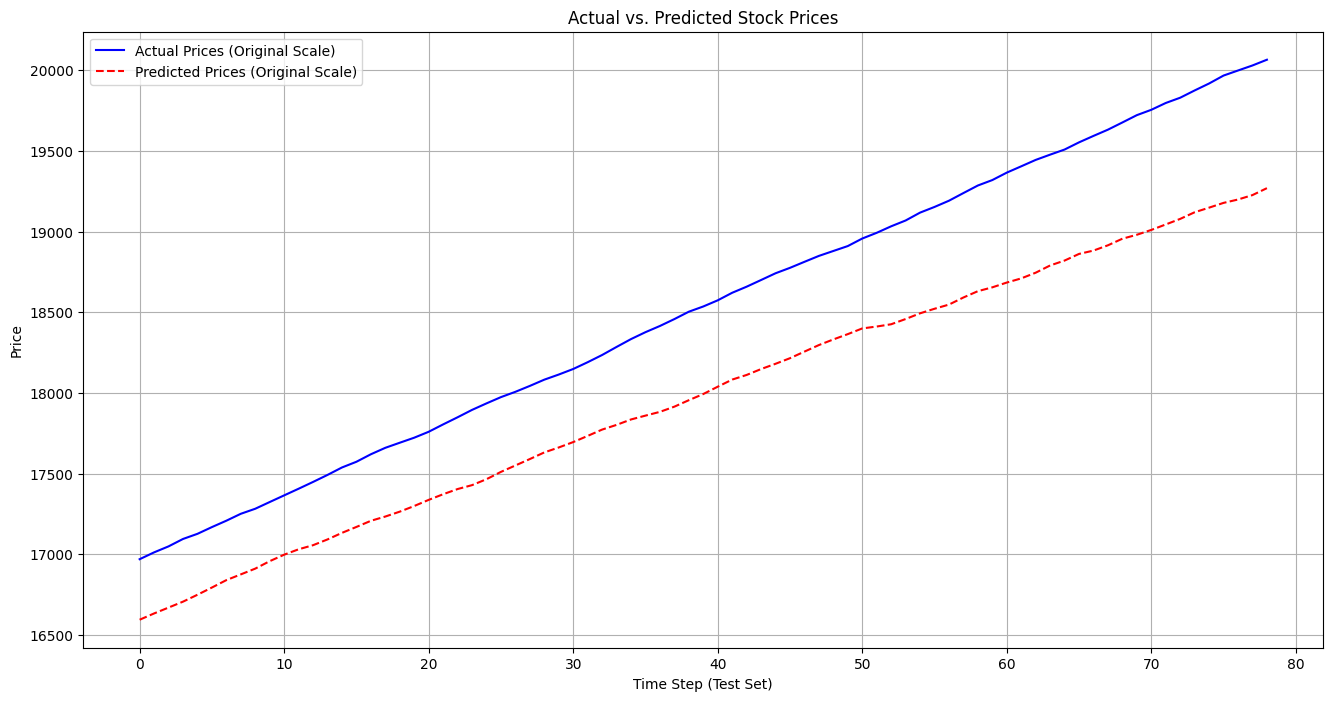

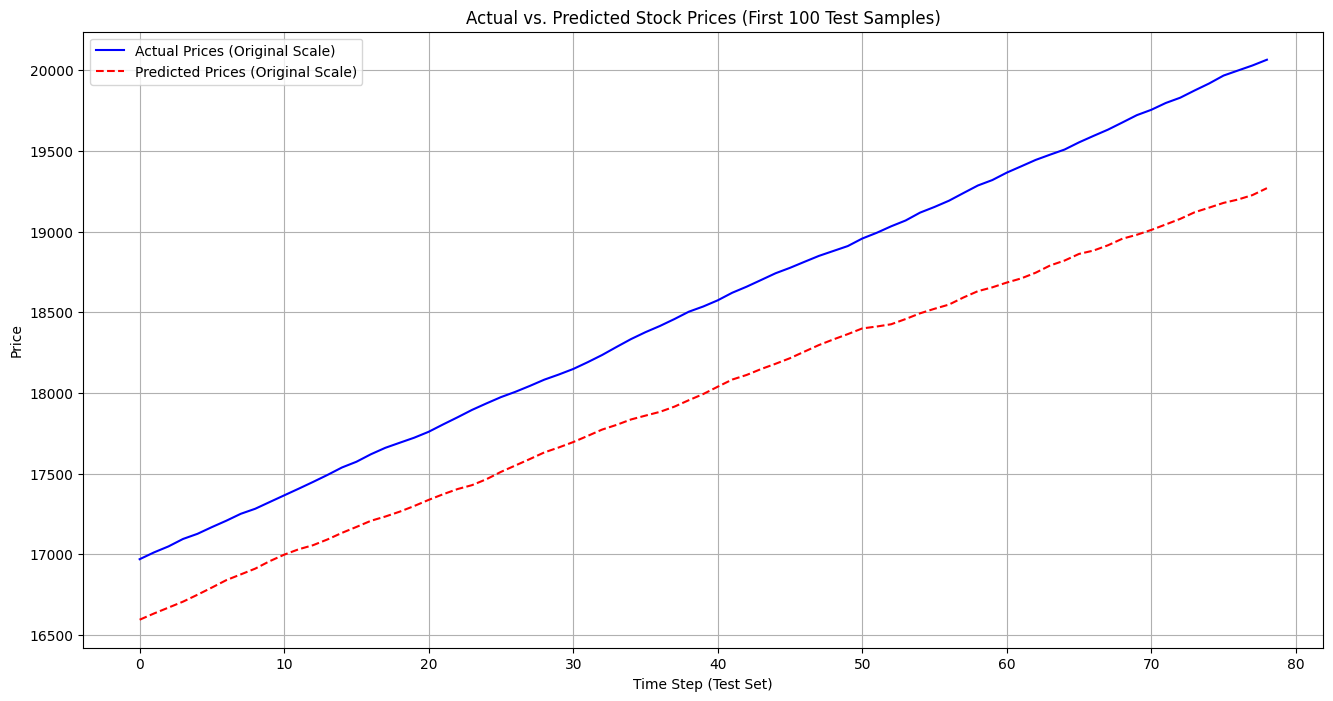


--- PyTorch LSTM Training and Evaluation Complete ---


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler # Assuming you have the scaler from previous step

# --- 0. Assume X_train, y_train, X_test, y_test, scaler are available from previous steps ---
# (Re-creating dummy data and preprocessing for a self-contained example)

# --- Dummy Data (from previous step, for self-contained execution) ---
# Create a slightly larger dummy DataFrame
date_range = pd.date_range(start='2016-01-01', periods=500, freq='B') # 500 business days
np.random.seed(42) # for reproducibility

dummy_data = {
    'open': np.random.uniform(30, 50, 500).cumsum() + 100,
    'high': np.random.uniform(30, 50, 500).cumsum() + 101,
    'low': np.random.uniform(30, 50, 500).cumsum() + 99,
    'close': np.random.uniform(30, 50, 500).cumsum() + 100,
    'adjclose': np.random.uniform(30, 50, 500).cumsum() + 100,
    'volume': np.random.randint(10_000_000, 100_000_000, 500),
    'ticker': ['GOOG'] * 500
}
dummy_data['high'] = np.maximum(dummy_data['open'], dummy_data['close']) + np.random.uniform(0.5, 2, 500)
dummy_data['low'] = np.minimum(dummy_data['open'], dummy_data['close']) - np.random.uniform(0.5, 2, 500)

df = pd.DataFrame(dummy_data, index=date_range)
df.index.name = 'timestamp'

# Feature Engineering
target_column = 'close'
df['daily_return'] = df[target_column].pct_change()
df['SMA_20'] = df[target_column].rolling(window=20).mean()
df['SMA_50'] = df[target_column].rolling(window=50).mean()
df['EMA_20'] = df[target_column].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df[target_column].ewm(span=50, adjust=False).mean()
df['volatility_20'] = df['daily_return'].rolling(window=20).std()
df.dropna(inplace=True)

# Data Scaling
features_to_scale = [col for col in df.columns if col not in ['ticker']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features_to_scale])
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale, index=df.index)

# Sequence Creation
timesteps = 60 # Look-back period
X = []
y = []
target_feature_index = scaled_df.columns.get_loc(target_column)

for i in range(timesteps, len(scaled_df)):
    X.append(scaled_df.iloc[i-timesteps:i].values)
    y.append(scaled_df.iloc[i, target_feature_index])

X = np.array(X)
y = np.array(y)

# Train-Test Split (Chronological)
train_split_ratio = 0.8
train_size = int(len(X) * train_split_ratio)

X_train_np, X_test_np = X[:train_size], X[train_size:]
y_train_np, y_test_np = y[:train_size], y[train_size:]

print(f"X_train_np shape: {X_train_np.shape}")
print(f"y_train_np shape: {y_train_np.shape}")
print(f"X_test_np shape: {X_test_np.shape}")
print(f"y_test_np shape: {y_test_np.shape}")
# --- End Dummy Data Recreation ---


# 1. Check for GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 2. Define the LSTM Model Architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        # Dropout layer (applied to the output of the LSTM layer)
        self.dropout = nn.Dropout(dropout_prob)
        
        # Fully connected layer (output layer)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        # h0 of shape (num_layers * num_directions, batch_size, hidden_size)
        # c0 of shape (num_layers * num_directions, batch_size, hidden_size)
        # For unidirectional LSTM, num_directions is 1
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Pass through LSTM layer
        # out: tensor of shape (batch_size, seq_len, hidden_size * num_directions)
        # hn: tensor of shape (num_layers * num_directions, batch_size, hidden_size)
        # cn: tensor of shape (num_layers * num_directions, batch_size, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # Take the output of the last time step
        # out.shape is (batch_size, timesteps, hidden_size)
        # We want the last timestep's output for prediction: out[:, -1, :]
        out = self.dropout(out[:, -1, :]) # Apply dropout to the last time step's output
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

# 3. Prepare Data for PyTorch
# Convert NumPy arrays to PyTorch Tensors
# Ensure y_train and y_test are 2D (num_samples, 1) for MSE loss
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1).to(device) # Unsqueeze to make it (samples, 1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1).to(device)

# Create TensorDataset and DataLoader
batch_size = 64 # You can adjust this
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # Shuffle can be True for training
                                                                                # but False is also fine for time series

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Keep False for evaluation consistency

# Define model parameters
input_size = X_train_np.shape[2] # Number of features per timestep
hidden_size = 128                # Number of features in the hidden state
num_layers = 2                   # Number of stacked LSTM layers
output_size = 1                  # Predicting a single value (close price)
learning_rate = 0.001
num_epochs = 100                 # Number of training epochs

# 4. Instantiate Model, Loss Function, and Optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nModel Architecture:\n{model}")
print(f"\nNumber of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


# 5. Train the Model
print("\n--- Starting Model Training ---")
train_losses = []
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad() # Clear gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update weights
        
    train_losses.append(loss.item()) # Store loss for plotting
        
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

print("--- Training Complete ---")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 6. Evaluate the Model
print("\n--- Evaluating Model on Test Set ---")
model.eval() # Set model to evaluation mode
test_predictions = []
actual_prices = []

with torch.no_grad(): # Disable gradient computation for inference
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        test_predictions.extend(outputs.cpu().numpy().flatten())
        actual_prices.extend(batch_y.cpu().numpy().flatten())

# Calculate test loss (MSE)
test_loss = criterion(torch.tensor(test_predictions).to(device), torch.tensor(actual_prices).to(device))
print(f"Test Loss (MSE): {test_loss.item():.6f}")

# Convert lists to NumPy arrays
test_predictions_np = np.array(test_predictions)
actual_prices_np = np.array(actual_prices)

# 7. Inverse Transform Predictions and Actual Values
# To inverse transform, we need to create a dummy array with the same number of features
# as the scaled_data used for scaler.fit_transform.
# Only the target column's predictions will be meaningful.

# Find the index of the 'close' column in 'features_to_scale' list
close_col_idx = features_to_scale.index('close')
num_features = len(features_to_scale)

# Inverse transform predictions
# Create a zero array for dummy features
dummy_predictions_array = np.zeros((len(test_predictions_np), num_features))
dummy_predictions_array[:, close_col_idx] = test_predictions_np # Place predictions in the correct column
# Inverse transform
original_predictions = scaler.inverse_transform(dummy_predictions_array)[:, close_col_idx]

# Inverse transform actual prices (y_test)
dummy_actual_array = np.zeros((len(actual_prices_np), num_features))
dummy_actual_array[:, close_col_idx] = actual_prices_np
original_actual_prices = scaler.inverse_transform(dummy_actual_array)[:, close_col_idx]

# Plotting Actual vs. Predicted Prices
plt.figure(figsize=(16, 8))
plt.plot(original_actual_prices, label='Actual Prices (Original Scale)', color='blue')
plt.plot(original_predictions, label='Predicted Prices (Original Scale)', color='red', linestyle='--')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time Step (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# You might want to plot a smaller segment for better detail
plt.figure(figsize=(16, 8))
plot_start_idx = 0
plot_end_idx = 100 # Plot first 100 predictions of the test set
plt.plot(original_actual_prices[plot_start_idx:plot_end_idx], label='Actual Prices (Original Scale)', color='blue')
plt.plot(original_predictions[plot_start_idx:plot_end_idx], label='Predicted Prices (Original Scale)', color='red', linestyle='--')
plt.title(f'Actual vs. Predicted Stock Prices (First {plot_end_idx} Test Samples)')
plt.xlabel('Time Step (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- PyTorch LSTM Training and Evaluation Complete ---")